In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.metrics import r2_score
import scipy.optimize

cities_all=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien']

In [2]:
city='Berlin'
df=pd.read_csv('../outputs/summary_stats/Berlin_stats.csv')
df['City']=city
df_all=df.copy()

for city in ['Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien']:
    df=pd.read_csv('../outputs/summary_stats/' + city + '_stats.csv')
    df['City']=city
    df_all=pd.concat([df_all,df])
df_all['City']=df_all['City'].replace('Wien','Vienna')

df_all

,Mode,Daily_Travel_cap,Mode_Share,Ownership,Avg_trip_dist,City
0,2_3_Wheel,0.147097,0.009730,NaN,NaN,Berlin
1,Bike,1.784387,0.118035,NaN,NaN,Berlin
2,Car,6.172215,0.408283,0.566624,NaN,Berlin
3,Foot,0.740811,0.049004,NaN,NaN,Berlin
4,Transit,6.272990,0.414949,NaN,NaN,Berlin
...,...,...,...,...,...,...
2,Car,10.101820,0.483798,0.662813,NaN,Vienna
3,Foot,0.909411,0.043554,NaN,NaN,Vienna
4,Transit,9.283379,0.444601,NaN,NaN,Vienna
5,All,20.880242,NaN,NaN,6.957265,Vienna


In [3]:
# convert to %
df_all['Mode_Share']=df_all['Mode_Share']*100

In [4]:
summ_UF=pd.read_csv('../outputs/summary_stats/summary_UF_all.csv')
summ_UF.rename(columns={'cities':'City'},inplace=True)
summ_UF['Pop.']=summ_UF['Population'].replace(',','',regex=True).astype(int)*1e-6
summ_UF['City']=summ_UF['City'].replace('Wien','Vienna')
summ_UF

,City,Population,Area,Pop. density,Built-up Density,Dist. to center,Dist. to subcenter,Intersec. Density,Street length avg.,Cycle lane share,Urban fabric area,Comm. area,Transit accessibility,Pop,Pop.
0,Berlin,3.748148e+06,891.177023,4205.840032,1.099656,8.501587,2.365113,23.649297,144.011945,5.17,25.237160,10.365251,2958.281595,3.748148,3.748148
1,Dresden,5.654610e+05,328.261060,1722.595424,0.544454,4.417224,2.948257,18.055751,140.135237,8.41,14.411046,7.430500,2406.562064,0.565461,0.565461
2,Düsseldorf,6.422470e+05,215.248167,2983.751307,1.071483,4.599795,2.555426,27.558887,117.115021,8.82,19.800080,13.654648,2133.974869,0.642247,0.642247
3,Frankfurt am Main,7.473180e+05,251.287907,2973.951304,0.299093,5.217463,2.187848,27.677779,121.508015,17.06,12.253403,12.084123,1439.983319,0.747318,0.747318
4,Kassel,2.049270e+05,108.101396,1895.692446,0.138494,3.085375,2.655072,25.577838,124.848445,4.50,18.994395,9.457040,931.920679,0.204927,0.204927
5,Leipzig,5.957760e+05,297.885248,2000.018480,0.739578,4.254474,2.389433,20.974520,130.186228,8.23,13.378511,12.289332,1414.379025,0.595776,0.595776
6,Magdeburg,2.424780e+05,201.683212,1202.271608,0.627584,2.734132,1.798200,15.593762,144.723497,13.26,9.740381,8.351608,1275.409414,0.242478,0.242478
7,Potsdam,1.782530e+05,188.339722,946.444002,0.259538,4.147738,2.007089,10.613799,147.280474,4.74,4.993357,2.677160,572.038101,0.178253,0.178253
8,Clermont,2.844050e+05,311.166203,913.997076,0.449788,2.389599,1.815130,25.336974,97.337483,3.00,12.089983,7.702762,1173.618374,0.284405,0.284405
9,Dijon,2.521200e+05,241.068735,1045.842798,0.404685,2.248755,2.536031,21.773911,105.650621,2.53,8.380765,7.753169,1355.590945,0.252120,0.252120


In [5]:
df_all=df_all.merge(summ_UF.loc[:,['City','Population','Dist. to center','Pop. density','Pop.']])
df_all.sort_values(by='Pop. density',ascending=False,inplace=True)
df_all

,Mode,Daily_Travel_cap,Mode_Share,Ownership,Avg_trip_dist,City,Population,Dist. to center,Pop. density,Pop.
107,Car,4.693219,40.231334,0.612123,NaN,Paris,6902389.0,6.718930,8466.314821,6.902389
106,Bike,0.147856,1.267453,NaN,NaN,Paris,6902389.0,6.718930,8466.314821,6.902389
110,All,11.665582,NaN,NaN,3.267682,Paris,6902389.0,6.718930,8466.314821,6.902389
109,Transit,5.818354,49.876244,NaN,NaN,Paris,6902389.0,6.718930,8466.314821,6.902389
108,Foot,0.704565,6.039688,NaN,NaN,Paris,6902389.0,6.718930,8466.314821,6.902389
...,...,...,...,...,...,...,...,...,...,...
60,Transit,1.734771,9.964036,NaN,NaN,Clermont,284405.0,2.389599,913.997076,0.284405
59,Foot,1.024528,5.884600,NaN,NaN,Clermont,284405.0,2.389599,913.997076,0.284405
58,Car,14.357098,82.463105,0.809340,NaN,Clermont,284405.0,2.389599,913.997076,0.284405
57,Bike,0.112977,0.648911,NaN,NaN,Clermont,284405.0,2.389599,913.997076,0.284405


In [6]:
df_mode=df_all.loc[:,['City','Pop. density','Mode_Share','Mode']]
#df_mode=df_all.drop(columns=['Daily_Travel_cap','Pop.','Area','Pop. Density'])

In [7]:
df_plot=pd.pivot(df_mode,index='City',columns='Mode',values='Mode_Share').reset_index()
df_plot=df_plot.merge(df_all.loc[:,['City','Pop. density']])
df_plot.sort_values(by='Pop. density',ascending=False,inplace=True)
df_plot.drop(columns='Pop. density',inplace=True)
df_plot.drop_duplicates(inplace=True)
df_plot.rename(columns={'2_3_Wheel':'2/3 Wheel'}, inplace=True)
df_plot=df_plot.loc[:,['City','Car','2/3 Wheel','Transit','Bike','Foot']]
df_plot

,City,Car,2/3 Wheel,Transit,Bike,Foot
110,Paris,40.231334,2.585280,49.876244,1.267453,6.039688
1,Berlin,40.828279,0.973024,41.494893,11.803452,4.900352
73,Madrid,54.635062,1.297741,38.677081,0.306095,5.084021
28,Düsseldorf,59.990118,0.643545,25.862058,9.048351,4.455928
41,Frankfurt am Main,56.918422,1.173037,26.059881,11.148573,4.700088
63,Lyon,64.801849,1.009732,27.067198,1.108004,6.013217
132,Vienna,48.379803,0.768749,44.460113,2.035968,4.355368
49,Leipzig,59.212759,1.181281,21.886182,12.284601,5.435178
43,Kassel,63.292420,0.299872,20.440347,8.975570,6.991790
57,Lille,77.986043,0.456435,16.231362,0.880176,4.445985


In [8]:
df_comp=df_plot.merge(summ_UF.loc[:,['City','Population','Pop. density']])
df_comp

,City,Car,2/3 Wheel,Transit,Bike,Foot,Population,Pop. density
0,Paris,40.231334,2.585280,49.876244,1.267453,6.039688,6.902389e+06,8466.314821
1,Berlin,40.828279,0.973024,41.494893,11.803452,4.900352,3.748148e+06,4205.840032
2,Madrid,54.635062,1.297741,38.677081,0.306095,5.084021,5.278678e+06,3901.726238
3,Düsseldorf,59.990118,0.643545,25.862058,9.048351,4.455928,6.422470e+05,2983.751307
4,Frankfurt am Main,56.918422,1.173037,26.059881,11.148573,4.700088,7.473180e+05,2973.951304
5,Lyon,64.801849,1.009732,27.067198,1.108004,6.013217,1.357466e+06,2471.526187
6,Vienna,48.379803,0.768749,44.460113,2.035968,4.355368,1.863662e+06,2175.630842
7,Leipzig,59.212759,1.181281,21.886182,12.284601,5.435178,5.957760e+05,2000.018480
8,Kassel,63.292420,0.299872,20.440347,8.975570,6.991790,2.049270e+05,1895.692446
9,Lille,77.986043,0.456435,16.231362,0.880176,4.445985,1.128691e+06,1840.849160


In [9]:
df_car_travel=df_all.loc[df_all['Mode']=='Car',]
df_car_travel['Country']='Germany'
df_car_travel.loc[df_car_travel['City'].isin(['Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse']),'Country']='France'
df_car_travel.loc[df_car_travel['City']=='Madrid','Country']='Spain'
df_car_travel.loc[df_car_travel['City']=='Vienna','Country']='Austria'

C:\Users\peter\AppData\Local\Temp\ipykernel_25432\1717820381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_car_travel['Country']='Germany'


In [10]:
df_car_travel.reset_index(inplace=True,drop=True)
df_car_travel

,Mode,Daily_Travel_cap,Mode_Share,Ownership,Avg_trip_dist,City,Population,Dist. to center,Pop. density,Pop.,Country
0,Car,4.693219,40.231334,0.612123,NaN,Paris,6.902389e+06,6.718930,8466.314821,6.902389,France
1,Car,6.172215,40.828279,0.566624,NaN,Berlin,3.748148e+06,8.501587,4205.840032,3.748148,Germany
2,Car,7.178261,54.635062,0.714697,NaN,Madrid,5.278678e+06,8.291385,3901.726238,5.278678,Spain
3,Car,9.733532,59.990118,0.724438,NaN,Düsseldorf,6.422470e+05,4.599795,2983.751307,0.642247,Germany
4,Car,8.727136,56.918422,0.737039,NaN,Frankfurt am Main,7.473180e+05,5.217463,2973.951304,0.747318,Germany
5,Car,10.711914,64.801849,0.707658,NaN,Lyon,1.357466e+06,4.710970,2471.526187,1.357466,France
6,Car,10.101820,48.379803,0.662813,NaN,Vienna,1.863662e+06,5.641626,2175.630842,1.863662,Austria
7,Car,8.315270,59.212759,0.630857,NaN,Leipzig,5.957760e+05,4.254474,2000.018480,0.595776,Germany
8,Car,8.471108,63.292420,0.727491,NaN,Kassel,2.049270e+05,3.085375,1895.692446,0.204927,Germany
9,Car,15.856150,77.986043,0.735994,NaN,Lille,1.128691e+06,6.248445,1840.849160,1.128691,France


In [11]:
df_comp[['Transit','Car','Foot','Population','Pop. density']].corr()

,Transit,Car,Foot,Population,Pop. density
Transit,1.000000,-0.922486,-0.305460,0.776981,0.756949
Car,-0.922486,1.000000,0.229075,-0.637635,-0.708259
Foot,-0.305460,0.229075,1.000000,-0.013512,0.054171
Population,0.776981,-0.637635,-0.013512,1.000000,0.904175
Pop. density,0.756949,-0.708259,0.054171,0.904175,1.000000


In [12]:
size_sort_pop=summ_UF.sort_values(by='Pop.',ascending=False).reset_index(drop=True)
size_sort_pop

,City,Population,Area,Pop. density,Built-up Density,Dist. to center,Dist. to subcenter,Intersec. Density,Street length avg.,Cycle lane share,Urban fabric area,Comm. area,Transit accessibility,Pop,Pop.
0,Paris,6.902389e+06,815.276675,8466.314821,2.266332,6.718930,2.961323,56.788084,100.943644,14.58,30.083879,17.488943,3947.365061,6.902389,6.902389
1,Madrid,5.278678e+06,1352.908453,3901.726238,0.980466,8.291385,2.051796,31.686546,104.077232,1.41,11.210862,11.955321,4360.055727,5.278678,5.278678
2,Berlin,3.748148e+06,891.177023,4205.840032,1.099656,8.501587,2.365113,23.649297,144.011945,5.17,25.237160,10.365251,2958.281595,3.748148,3.748148
3,Vienna,1.863662e+06,856.607639,2175.630842,1.104469,5.641626,2.776235,19.675286,132.392248,2.85,13.900583,7.185112,2217.181645,1.863662,1.863662
4,Lyon,1.357466e+06,549.242006,2471.526187,0.972397,4.710970,2.831139,32.195280,114.131999,6.86,23.448676,11.714617,1966.669939,1.357466,1.357466
5,Lille,1.128691e+06,613.136060,1840.849160,0.707737,6.248445,1.933862,33.703770,102.382863,8.56,22.058479,12.419867,1169.343672,1.128691,1.128691
6,Toulouse,9.021580e+05,781.360510,1154.598919,0.519183,3.949149,2.336310,27.628722,102.339567,4.39,21.966689,9.346652,1439.400493,0.902158,0.902158
7,Frankfurt am Main,7.473180e+05,251.287907,2973.951304,0.299093,5.217463,2.187848,27.677779,121.508015,17.06,12.253403,12.084123,1439.983319,0.747318,0.747318
8,Düsseldorf,6.422470e+05,215.248167,2983.751307,1.071483,4.599795,2.555426,27.558887,117.115021,8.82,19.800080,13.654648,2133.974869,0.642247,0.642247
9,Nantes,6.288680e+05,535.127489,1175.174165,0.474382,3.872439,2.555509,27.708145,99.258628,17.09,16.262252,8.531165,1805.178008,0.628868,0.628868


In [13]:
size_sort_dens=summ_UF.sort_values(by='Pop. density',ascending=False).reset_index(drop=True)
size_sort_dens

,City,Population,Area,Pop. density,Built-up Density,Dist. to center,Dist. to subcenter,Intersec. Density,Street length avg.,Cycle lane share,Urban fabric area,Comm. area,Transit accessibility,Pop,Pop.
0,Paris,6.902389e+06,815.276675,8466.314821,2.266332,6.718930,2.961323,56.788084,100.943644,14.58,30.083879,17.488943,3947.365061,6.902389,6.902389
1,Berlin,3.748148e+06,891.177023,4205.840032,1.099656,8.501587,2.365113,23.649297,144.011945,5.17,25.237160,10.365251,2958.281595,3.748148,3.748148
2,Madrid,5.278678e+06,1352.908453,3901.726238,0.980466,8.291385,2.051796,31.686546,104.077232,1.41,11.210862,11.955321,4360.055727,5.278678,5.278678
3,Düsseldorf,6.422470e+05,215.248167,2983.751307,1.071483,4.599795,2.555426,27.558887,117.115021,8.82,19.800080,13.654648,2133.974869,0.642247,0.642247
4,Frankfurt am Main,7.473180e+05,251.287907,2973.951304,0.299093,5.217463,2.187848,27.677779,121.508015,17.06,12.253403,12.084123,1439.983319,0.747318,0.747318
5,Lyon,1.357466e+06,549.242006,2471.526187,0.972397,4.710970,2.831139,32.195280,114.131999,6.86,23.448676,11.714617,1966.669939,1.357466,1.357466
6,Vienna,1.863662e+06,856.607639,2175.630842,1.104469,5.641626,2.776235,19.675286,132.392248,2.85,13.900583,7.185112,2217.181645,1.863662,1.863662
7,Leipzig,5.957760e+05,297.885248,2000.018480,0.739578,4.254474,2.389433,20.974520,130.186228,8.23,13.378511,12.289332,1414.379025,0.595776,0.595776
8,Kassel,2.049270e+05,108.101396,1895.692446,0.138494,3.085375,2.655072,25.577838,124.848445,4.50,18.994395,9.457040,931.920679,0.204927,0.204927
9,Lille,1.128691e+06,613.136060,1840.849160,0.707737,6.248445,1.933862,33.703770,102.382863,8.56,22.058479,12.419867,1169.343672,1.128691,1.128691


In [14]:
xt = np.array(range(0, 19))

In [15]:
df_plot2=pd.pivot(df_mode,index='City',columns='Mode',values='Mode_Share').reset_index()
df_plot2=df_plot2.merge(df_all.loc[:,['City','Pop.']])
df_plot2.sort_values(by='Pop.',ascending=False,inplace=True)
df_plot2.drop(columns=['Pop.','All'],inplace=True)
df_plot2.drop_duplicates(inplace=True)
df_plot2.rename(columns={'2_3_Wheel':'2/3 Wheel'}, inplace=True)
df_plot2=df_plot2.loc[:,['City','Car','2/3 Wheel','Transit','Bike','Foot']]
df_plot2

,City,Car,2/3 Wheel,Transit,Bike,Foot
111,Paris,40.231334,2.585280,49.876244,1.267453,6.039688
71,Madrid,54.635062,1.297741,38.677081,0.306095,5.084021
1,Berlin,40.828279,0.973024,41.494893,11.803452,4.900352
126,Vienna,48.379803,0.768749,44.460113,2.035968,4.355368
66,Lyon,64.801849,1.009732,27.067198,1.108004,6.013217
57,Lille,77.986043,0.456435,16.231362,0.880176,4.445985
119,Toulouse,75.000649,1.592731,18.664031,1.439976,3.302612
41,Frankfurt am Main,56.918422,1.173037,26.059881,11.148573,4.700088
29,Düsseldorf,59.990118,0.643545,25.862058,9.048351,4.455928
95,Nantes,75.177027,1.142087,18.142781,1.514009,4.024096


In [16]:
sns.set_palette(sns.color_palette('tab10'))

C:\Users\peter\AppData\Local\Temp\ipykernel_25432\602288314.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(size_sort_dens['City'].values)


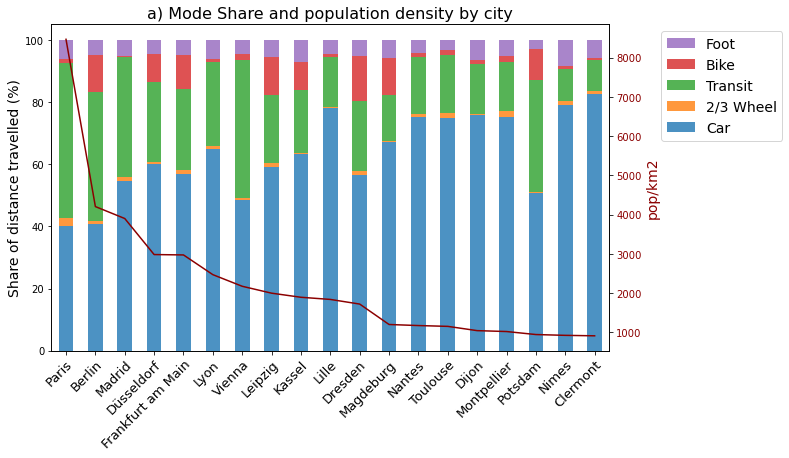

In [17]:
sns.set_palette(sns.color_palette('tab10'))
fig, ax1 = plt.subplots(figsize=(10,6))
df_plot.plot(kind='bar', stacked=True,ax=ax1,alpha=0.8)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.08, 1.0),fontsize=14)
ax1.set_xticklabels(df_plot['City'].values)
plt.xticks(rotation = 45,fontsize=13,ha='right',rotation_mode='anchor')
#plt.xlabel('Distance Bands (km)',fontsize=12)
plt.ylabel('Share of distance travelled (%)',fontsize=14)
plt.title('a) Mode Share and population density by city',fontsize=16)

ax2 = ax1.twinx() 
c='darkred'
ax2.plot(size_sort_dens['City'],size_sort_dens['Pop. density'],color=c)
ax2.set_ylabel('pop/km2', color=c,fontsize=14)
ax2.set_xticklabels(size_sort_dens['City'].values)
ax2.xaxis.set_major_locator(mticker.FixedLocator(xt))
ax2.tick_params(axis='y', labelcolor=c)

plt.savefig('../figures/summary_all/mode_density_bar.png',facecolor='w',dpi=65,bbox_inches='tight')


C:\Users\peter\AppData\Local\Temp\ipykernel_25432\3581206263.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(size_sort_pop['City'].values)


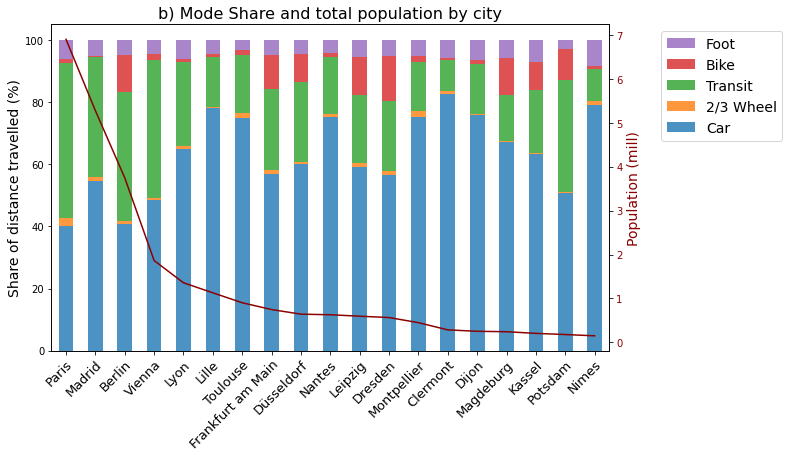

In [18]:
fig, ax1 = plt.subplots(figsize=(10,6))
df_plot2.plot(kind='bar', stacked=True,ax=ax1,alpha=0.8)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.08, 1.0),fontsize=14)
ax1.set_xticklabels(df_plot2['City'].values)
plt.xticks(rotation = 45,fontsize=13,ha='right',rotation_mode='anchor')
plt.ylabel('Share of distance travelled (%)',fontsize=14)
plt.title('b) Mode Share and total population by city',fontsize=16)

ax2 = ax1.twinx() 
c='darkred'
ax2.plot(size_sort_pop['City'],size_sort_pop['Pop.'],color=c)
ax2.set_ylabel('Population (mill)', color=c,fontsize=14)
ax2.set_xticklabels(size_sort_pop['City'].values)
ax2.xaxis.set_major_locator(mticker.FixedLocator(xt))
ax2.tick_params(axis='y', labelcolor=c)
plt.savefig('../figures/summary_all/mode_pop_bar.png',facecolor='w',dpi=65,bbox_inches='tight')

In [19]:
# plot car mode share and ownership vs income for all cities with income data
inc_de=pd.read_csv('../figures/plots/income_stats_DE.csv')
inc_de['Country']='DE'

inc_fr=pd.read_csv('../figures/plots/income_stats_FR.csv')
inc_fr['Country']='FR'
inc_par=pd.read_csv('../figures/plots/income_stats_Paris.csv')
inc_par['Country']='FR'
inc_fr=pd.concat([inc_fr,inc_par])

inc=pd.concat([inc_de,inc_fr])
inc.reset_index(drop=True,inplace=True)
inc.loc[:,('CarOwnershipHH','Car_ModeShare')]=100*inc.loc[:,('CarOwnershipHH','Car_ModeShare')]
inc=inc.loc[inc['N_HH']>9,]
inc['City']=inc['City'].replace('Wien','Vienna')
inc

,Income,CarOwnershipHH,Trip_Distance,Trip_Distance_Car,Car_ModeShare,City,N_HH,Country,CarAvailable
0,350.0,23.595506,14.947719,3.347351,22.393723,Berlin,89.0,DE,NaN
1,700.0,21.179625,15.623103,2.750800,17.607260,Berlin,373.0,DE,NaN
2,1200.0,38.309637,16.471699,5.235560,31.785186,Berlin,1266.0,DE,NaN
3,1750.0,53.955606,16.700901,6.626735,39.678905,Berlin,1757.0,DE,NaN
4,2300.0,66.178624,17.738077,7.960941,44.880521,Berlin,2049.0,DE,NaN
...,...,...,...,...,...,...,...,...,...
98,2700.0,68.951194,14.417273,6.652229,46.140693,Paris,963.0,FR,NaN
99,3250.0,78.278689,15.062989,6.704398,44.509083,Paris,732.0,FR,NaN
100,4000.0,83.118406,15.614525,7.391276,47.335900,Paris,853.0,FR,NaN
101,5000.0,85.361217,15.267702,6.948787,45.512988,Paris,526.0,FR,NaN


In [20]:
inc['Region']=inc['City']
inc.loc[(inc['Country']=='DE') & (inc['City']!='Berlin'),'Region']='DE, other'
inc.loc[(inc['Country']=='FR') & (inc['City']!='Paris'),'Region']='FR, other'
inc

,Income,CarOwnershipHH,Trip_Distance,Trip_Distance_Car,Car_ModeShare,City,N_HH,Country,CarAvailable,Region
0,350.0,23.595506,14.947719,3.347351,22.393723,Berlin,89.0,DE,NaN,Berlin
1,700.0,21.179625,15.623103,2.750800,17.607260,Berlin,373.0,DE,NaN,Berlin
2,1200.0,38.309637,16.471699,5.235560,31.785186,Berlin,1266.0,DE,NaN,Berlin
3,1750.0,53.955606,16.700901,6.626735,39.678905,Berlin,1757.0,DE,NaN,Berlin
4,2300.0,66.178624,17.738077,7.960941,44.880521,Berlin,2049.0,DE,NaN,Berlin
...,...,...,...,...,...,...,...,...,...,...
98,2700.0,68.951194,14.417273,6.652229,46.140693,Paris,963.0,FR,NaN,Paris
99,3250.0,78.278689,15.062989,6.704398,44.509083,Paris,732.0,FR,NaN,Paris
100,4000.0,83.118406,15.614525,7.391276,47.335900,Paris,853.0,FR,NaN,Paris
101,5000.0,85.361217,15.267702,6.948787,45.512988,Paris,526.0,FR,NaN,Paris


In [21]:
inc['Region2']=inc['City']
inc.loc[inc['City'].isin(['Kassel','Magdeburg']),'Region2']='DE, small'
inc.loc[inc['City'].isin(['Frankfurt am Main','Dresden','Leipzig','Düsseldorf']),'Region2']='DE, mid'
inc

,Income,CarOwnershipHH,Trip_Distance,Trip_Distance_Car,Car_ModeShare,City,N_HH,Country,CarAvailable,Region,Region2
0,350.0,23.595506,14.947719,3.347351,22.393723,Berlin,89.0,DE,NaN,Berlin,Berlin
1,700.0,21.179625,15.623103,2.750800,17.607260,Berlin,373.0,DE,NaN,Berlin,Berlin
2,1200.0,38.309637,16.471699,5.235560,31.785186,Berlin,1266.0,DE,NaN,Berlin,Berlin
3,1750.0,53.955606,16.700901,6.626735,39.678905,Berlin,1757.0,DE,NaN,Berlin,Berlin
4,2300.0,66.178624,17.738077,7.960941,44.880521,Berlin,2049.0,DE,NaN,Berlin,Berlin
...,...,...,...,...,...,...,...,...,...,...,...
98,2700.0,68.951194,14.417273,6.652229,46.140693,Paris,963.0,FR,NaN,Paris,Paris
99,3250.0,78.278689,15.062989,6.704398,44.509083,Paris,732.0,FR,NaN,Paris,Paris
100,4000.0,83.118406,15.614525,7.391276,47.335900,Paris,853.0,FR,NaN,Paris,Paris
101,5000.0,85.361217,15.267702,6.948787,45.512988,Paris,526.0,FR,NaN,Paris,Paris


In [22]:
cp=['tab:blue','tab:orange','tab:green','tab:brown','tab:purple','tab:gray','tab:red']

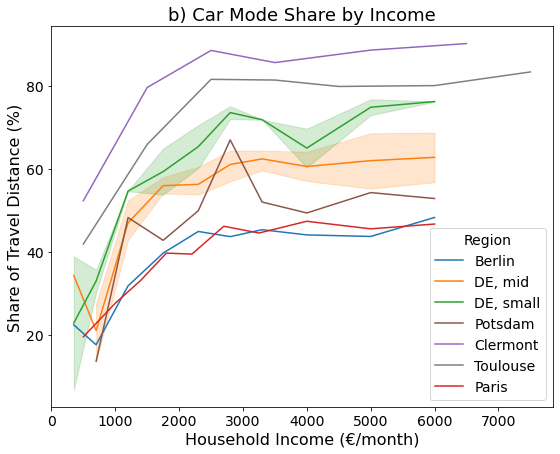

In [23]:
fig, ax = plt.subplots(figsize=(9,7))
sns.lineplot(ax=ax,x='Income', y='Car_ModeShare', data=inc, hue='Region2',alpha=1,palette=cp)
# pass handle & labels lists along with order as below
plt.legend(title='Region', fontsize=14,title_fontsize=14)
plt.title('b) Car Mode Share by Income',fontsize=18)
#plt.legend(title='Region', fontsize=14)
plt.xlabel('Household Income (€/month)',fontsize=16)
plt.ylabel('Share of Travel Distance (%)',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.savefig('../figures/plots/All_CarModeShare_new.png',facecolor='w',dpi=65,bbox_inches='tight')


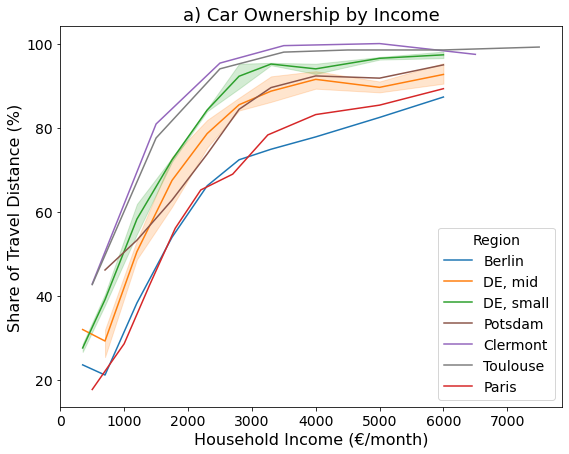

In [24]:
fig, ax = plt.subplots(figsize=(9,7))
sns.lineplot(ax=ax,x='Income', y='CarOwnershipHH', data=inc, hue='Region2',alpha=1,palette=cp)
# pass handle & labels lists along with order as below
plt.legend(title='Region', fontsize=14,title_fontsize=14)
plt.title('a) Car Ownership by Income',fontsize=18)
#plt.legend(title='Region', fontsize=14)
plt.xlabel('Household Income (€/month)',fontsize=16)
plt.ylabel('Share of Travel Distance (%)',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('../figures/plots/All_CarOwnership_new.png',facecolor='w',dpi=65,bbox_inches='tight')
